In [91]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [92]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

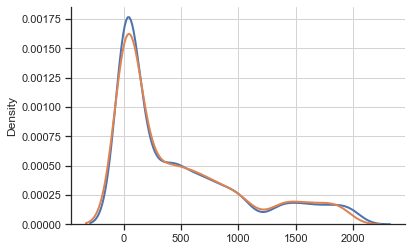

In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
# X, y, features, categ, sch_nan = ds.load_smarto_dataset()
X, y, features, categ, sch_nan = ds.load_support2_dataset()
# X, y, features, categ, sch_nan = ds.load_rott2_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

<Axes: ylabel='Density'>

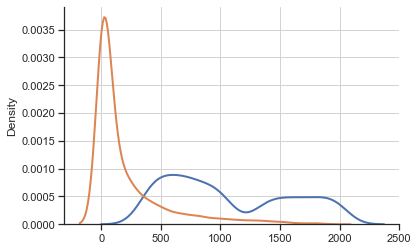

In [17]:
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 0)[0]]["time"], label="train")
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 1)[0]]["time"], label="train")

(0.0, 2029.0)

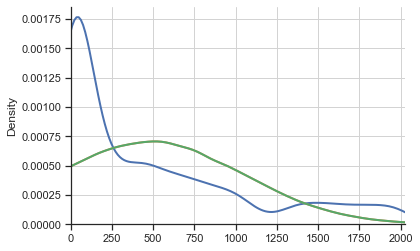

In [30]:
import scipy.stats as stats
from scipy.optimize import root, fsolve

def equations(l_var, mu_e, sigma_e):
    mu, sigma = l_var
    alpha = -mu/sigma
    phi_a = 1/np.sqrt(2*np.pi) * np.exp(-1/2*(alpha**2))
    Z = 1 - stats.norm.cdf(alpha)
    eq1 = mu + phi_a * sigma / Z - mu_e + (mu < 0)*np.exp(-mu*1e5)
    eq2 = ((sigma / sigma_e)**2) * (1 + alpha*phi_a/Z - (phi_a/Z)**2) - 1 + (sigma < 0)*np.exp(-sigma*1e5)
    return [eq1, eq2]


class TruncNorm:
    _ctor_param = {"name": "TruncNorm"}
    @staticmethod
    def fit(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        solution = fsolve(equations, [mu_e, sigma_e], args=(mu_e, sigma_e))
        return solution
#         solution = root(lambda x: equations(x, mu_e, sigma_e), [mu_e, sigma_e])
#         print("Solution:", solution.x)
#         return solution.x

    @staticmethod
    def rvs(mu, sigma, size, random_state=42):
        return stats.norm.rvs(mu, sigma, size=size, random_state=random_state)
    
    @staticmethod
    def valid(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        params = TruncNorm.fit(y)
        a = TruncNorm.rvs(*params, size=100000, random_state=42)
        a = a[a > 0]
        print(mu_e, np.mean(a))
        print(sigma_e, np.std(a))
        

sns.kdeplot(y_tr["time"])
for st in [stats.norm, TruncNorm, 
#            stats.lognorm, stats.gamma, stats.laplace, stats.laplace_asymmetric, 
#            stats.rayleigh, stats.weibull_min, stats.genlogistic
          ]:
    params = st.fit(y_tr["time"])
    sns.kdeplot(st.rvs(*params, size=100000, random_state=42))
plt.xlim((0, y_tr["time"].max()))

In [45]:
st.rvs(*params, size=100000, random_state=42)

array([756.78487926, 400.97311613, 841.38375312, ..., 707.73774359,
       360.16411764, 545.72743155])

In [31]:
# TruncNorm.valid(y_["time"])
TruncNorm.valid(y["time"])

478.44986271279515 672.3651074279494
560.3524982368881 429.66491014362714


In [33]:
np.unique(y["time"])

array([   3.,    4.,    5., ..., 2027., 2028., 2029.])

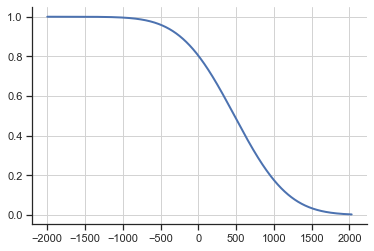

In [35]:
params = TruncNorm.fit(y["time"])

a = TruncNorm.rvs(*params, size=100000, random_state=42)
a = a[a > 0]
    
x = np.linspace(-2000, y["time"].max(), 1000)
plt.plot(x, stats.norm.sf(x, *params))

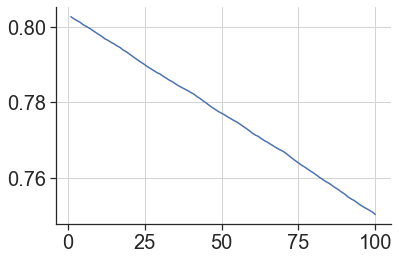

In [48]:
km = KaplanMeier()
km.fit(durations=st.rvs(*params, size=100000), right_censor=np.ones(100000))
plt.plot(x, km.survival_function_at_times(x))

### Informative censuring comparison

In [37]:
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_smarto_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.19005, AUPRC:0.84023
SF1 IBS:0.17410, AUPRC:0.86675
SF2 IBS:0.17323, AUPRC:0.85589


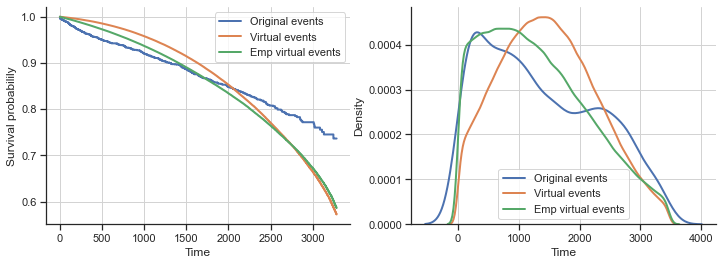

In [151]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, size=1000000, *args, **kwargs):
        self.d_type = d_type
        self.size = size
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None, censuring=True):
#         q1, q2 = np.quantile(durations, [0.05, 0.95])
        params = self.d_type.fit(durations)
#         params = self.d_type.fit(durations[right_censor == 1])
#         params = list(params)
#         params[1] = params[1] / np.sqrt(1.5)
        self.durs = self.d_type.rvs(*params, size=self.size, random_state=self.size)
        if censuring:
            self.events = np.random.choice(right_censor, size=self.size, replace=True)
        else:
            self.events = np.ones_like(self.durs)
        self.durs = np.hstack([durations.copy(), self.durs])
        self.events = np.hstack([right_censor.copy(), self.events])

        ind = (self.durs >= durations.min()) & (self.durs <= durations.max())
#         ind = (self.durs >= q1) & (self.durs <= q2)
        self.events = self.events[ind]
        self.durs = self.durs[ind]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterEmp(KaplanMeierZeroAfter):
    """
    Nonparametric model with virtual events generated by bootstrap meaning
    """
    def __init__(self, n=2, *args, **kwargs):
        self.n = n
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.choice(durations, size=(self.n, 20000), replace=True).mean(axis=0)
        self.events = np.random.choice(right_censor, size=20000, replace=True)
        
        super().fit(self.durs, self.events)

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfterTh(stats.norm)
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

km2 = KaplanMeierZeroAfterTh(TruncNorm)
# km2 = KaplanMeierZeroAfterEmp(2)
km2.fit(y_["time"], y_["cens"])
sf2 = km2.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf2 = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf2 = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].step(bins_HO, sf2, label="Emp virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
sns.kdeplot(km2.durs, ax=axes[1], label="Emp virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
print(f"SF2 IBS:{ibs_sf2:.5f}, AUPRC:{auprc_sf2:.5f}")

In [121]:
from tqdm import tqdm
from joblib import Parallel, delayed

def get_km_ibs(y, bins_HO, s, rs=42):
    np.random.seed(rs)
    km = KaplanMeierZeroAfterTh(TruncNorm, size=s)
    km.fit(y["time"], y["cens"])
    sf = km.survival_function_at_times(bins_HO)
    ibs_sf_ = metr.ibs_remain(y, y, np.repeat(sf[np.newaxis, :], y.shape[0], axis=0), bins_HO)
    auprc_sf_ = metr.auprc(y, y, np.repeat(sf[np.newaxis, :], y.shape[0], axis=0), bins_HO)
    return ibs_sf_, auprc_sf_, sf

sizes = np.hstack([0, 10**np.arange(1, 7)])
repeats = 1000
d = {"sizes": [], "ibs": [], "auprc": [], "sf": []}
for s in sizes:
    print(s)
    with Parallel(n_jobs=20, verbose=1) as parallel:
        ml = parallel(delayed(get_km_ibs)(y, bins_HO, s, rs=rs) for rs in range(repeats))
    d["ibs"] += [m[0] for m in ml]
    d["auprc"] += [m[1] for m in ml]
    d["sf"] += [m[2] for m in ml]
    d["sizes"] += [s for _ in range(repeats)]
    
#     for rs in tqdm(range(repeats), ncols=20, ascii=True, desc='Total'):
#         ibs_sf_ = get_km_ibs(y, bins_HO, s, rs=rs)
#         d["ibs"].append(ibs_sf_)
#         d["sizes"].append(s)

0


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   26.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   59.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  2.3min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


10


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   21.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   54.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  2.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


100


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   22.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   54.6s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  2.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   22.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   54.8s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  2.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


10000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   22.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   54.9s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  2.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


100000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   22.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   55.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  2.2min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1000000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   34.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  2.6min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  3.5min finished


<Axes: xlabel='sizes', ylabel='auprc'>

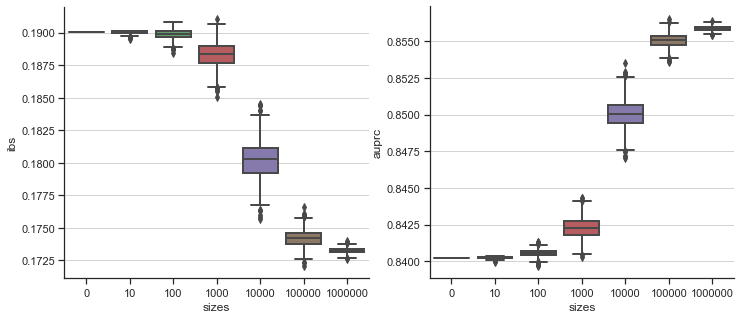

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.boxplot(pd.DataFrame(d), y="ibs", x="sizes", ax=axes[0])
sns.boxplot(pd.DataFrame(d), y="auprc", x="sizes", ax=axes[1])

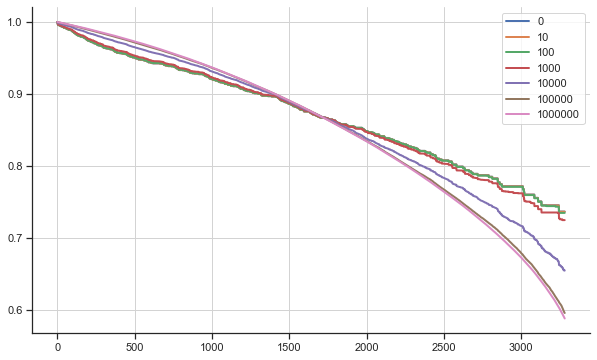

In [135]:
fig, axes = plt.subplots(figsize=(10, 6))
for s, r in pd.DataFrame(d).groupby("sizes")["sf"].agg(np.mean).items():
    axes.plot(r, label=s)
plt.legend()

<Axes: xlabel='ibs', ylabel='Density'>

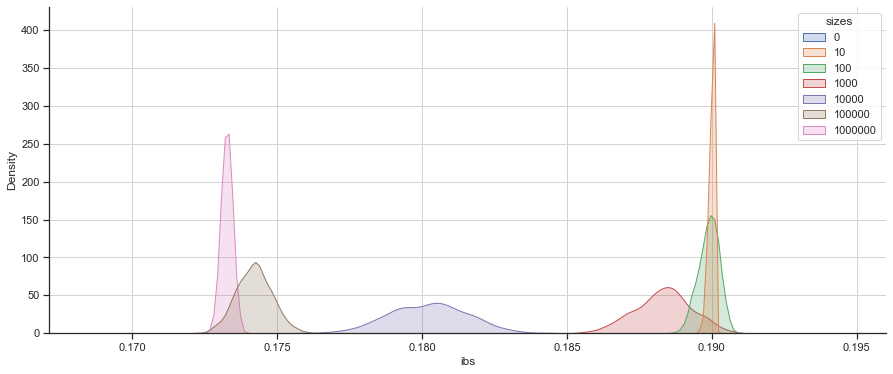

In [147]:
fig, axes = plt.subplots(figsize=(15, 6))
df_res = pd.DataFrame(d)
df_res["sizes"] = df_res["sizes"].astype("category")
sns.kdeplot(df_res, x="ibs", hue="sizes", ax=axes, 
            hue_order=sizes,
            common_grid=True, fill=True)

In [138]:
df_res

,sizes,ibs,auprc,sf
0,0,0.190054,0.840233,"[1.0, 0.9994836044410018, 0.9971598244255099, ..."
1,0,0.190054,0.840233,"[1.0, 0.9994836044410018, 0.9971598244255099, ..."
2,0,0.190054,0.840233,"[1.0, 0.9994836044410018, 0.9971598244255099, ..."
3,0,0.190054,0.840233,"[1.0, 0.9994836044410018, 0.9971598244255099, ..."
4,0,0.190054,0.840233,"[1.0, 0.9994836044410018, 0.9971598244255099, ..."
...,...,...,...,...
6995,1000000,0.173505,0.855628,"[1.0, 0.9999473882737547, 0.9998962210367744, ..."
6996,1000000,0.173449,0.855684,"[1.0, 0.9999561557087705, 0.9998947524353399, ..."
6997,1000000,0.173656,0.856071,"[1.0, 0.999940078078878, 0.9998889102305154, 0..."
6998,1000000,0.173066,0.855505,"[1.0, 0.999953233026642, 0.9998772124452788, 0..."


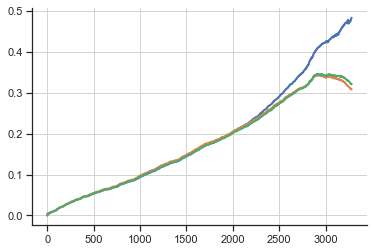

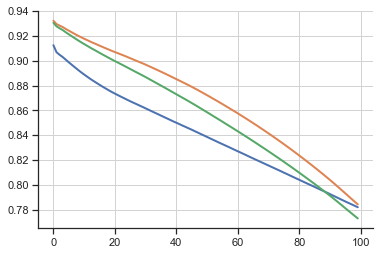

In [40]:
ibs_sf_ = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf1_ = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf2_ = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)

plt.plot(ibs_sf_)
plt.plot(ibs_sf1_)
plt.plot(ibs_sf2_)
plt.show()

auprc_sf_ = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf1_ = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf2_ = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
plt.plot(auprc_sf_)
plt.plot(auprc_sf1_)
plt.plot(auprc_sf2_)
plt.show()

<Axes: >

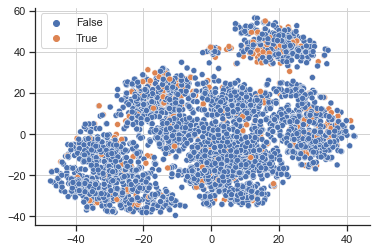

In [41]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42).fit_transform(X_scaled)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=y["cens"])

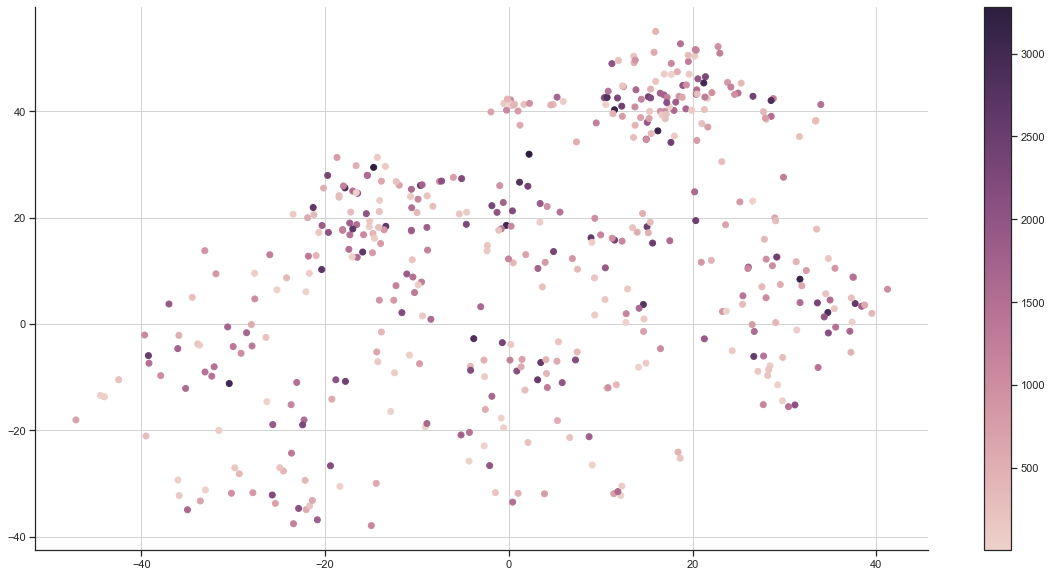

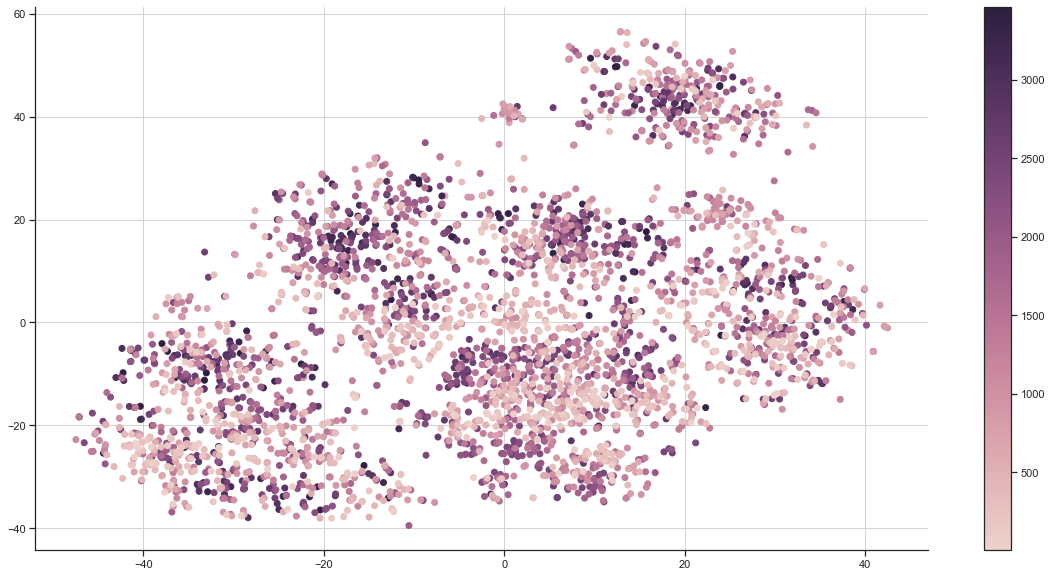

In [42]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 1)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 0)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

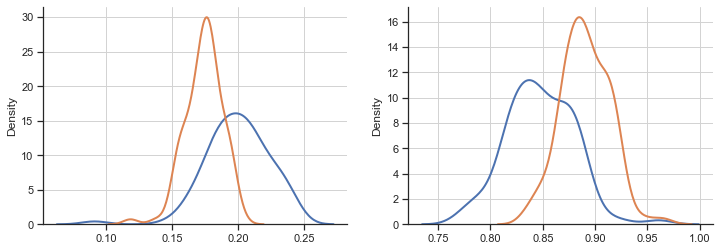

0.1996&0.1740&1.471e-16
0.8476&0.8908&1.070e-21


Text(0, 0.5, '$AUPRC$')

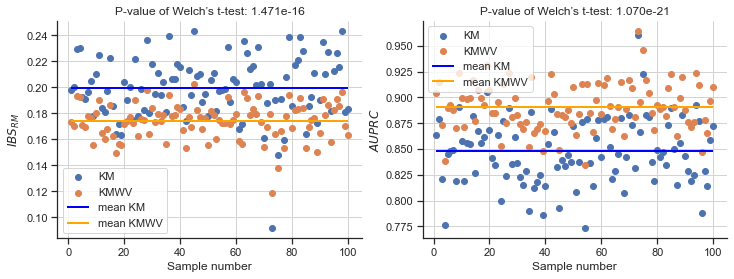

In [43]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
#     km = KaplanMeierZeroAfterTh(TruncNorm)
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfterTh(stats.norm)
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [44]:
from survivors.tree import CRAID

def split_by_tree(X, y, categ=[]):
    p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 5, 
         'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 0.05, 'woe': True}

    tree = CRAID(**p)
    tree.fit(X, y)
    return tree.predict(X, target="numb")
    

def print_metric_by_nonparam(df, subsample=0.3, prefix="", censuring=True, categ=[]):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i in range(int(1/subsample*5)):
        x_sub = df.sample(n=int(df.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_src = cnt.get_y(cens=cens, time=time)
        
        strats = [y_src]
        
#         if tree:
#             X_ = x_sub[[c for c in x_sub.columns if not(c in ["time", "cens"])]]
#             nodes = split_by_tree(X_, y_src, categ=categ)
#             strats = [y_src[np.where(nodes == n)[0]] for n in set(nodes)]
#         print(len(strats))
        for y_v in strats:
            for th in ["", 2, 4, 6, stats.norm, TruncNorm, stats.lognorm, stats.gamma, stats.laplace, 
                       stats.laplace_asymmetric, stats.rayleigh, stats.weibull_min, stats.genlogistic]:
                if th == "":
                    suff = "km"
                    km = KaplanMeierZeroAfter()
                elif isinstance(th, int):
                    suff = f"Emp({th})"
                    km = KaplanMeierZeroAfterEmp(th, censuring=censuring)
                else:
                    suff = th._ctor_param["name"]
                    km = KaplanMeierZeroAfterTh(th, censuring=censuring)
                km.fit(y_v["time"], y_v["cens"])
                sf = km.survival_function_at_times(bins_)

                ibs_ = metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                auprc_ = metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                if suff+"IBS" in d:
                    d[suff+"IBS"].append(ibs_)
                else:
                    d[suff+"IBS"] = [ibs_]
                if suff+"AUPRC" in d:
                    d[suff+"AUPRC"].append(auprc_)
                else:
                    d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [419]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    
    for subsample in [1, 0.7, 0.5, 0.3, 0.1, 0.05]:
        d = print_metric_by_nonparam(df, subsample=subsample, prefix=ds_name, censuring=False)
        l.append(d)
        print(d)
#     d = print_metric_by_nonparam(df, subsample=0.3, prefix=ds_name)
#     print(d)
#     l.append(d)
#     d = print_metric_by_nonparam(df, subsample=0.05, prefix=ds_name)
#     print(d)
#     l.append(d)
    
df_res = pd.DataFrame(l).T

{'kmIBS': 0.1845759382639201, 'kmAUPRC': 0.5896996848462435, 'Emp(2)IBS': 0.1583308123211333, 'Emp(2)AUPRC': 0.6884718894910135, 'Emp(4)IBS': 0.16429807145514436, 'Emp(4)AUPRC': 0.6990180811911446, 'Emp(6)IBS': 0.17127907953450358, 'Emp(6)AUPRC': 0.7011332457279345, 'normIBS': 0.16510157366903838, 'normAUPRC': 0.6790646210139722, 'TruncNormIBS': 0.16201601839872884, 'TruncNormAUPRC': 0.6667149763122071, 'lognormIBS': 0.16016323931208046, 'lognormAUPRC': 0.6711599389794303, 'gammaIBS': 0.15955010878276837, 'gammaAUPRC': 0.6680573681097071, 'laplaceIBS': 0.1613363072856333, 'laplaceAUPRC': 0.6776610981520108, 'laplace_asymmetricIBS': 0.15633487349758157, 'laplace_asymmetricAUPRC': 0.6607974802744401, 'rayleighIBS': 0.16125863685403466, 'rayleighAUPRC': 0.6706048956139821, 'weibull_minIBS': 0.1608266284160765, 'weibull_minAUPRC': 0.6691173666614063, 'genlogisticIBS': 0.15925927267890813, 'genlogisticAUPRC': 0.6693510312913176, 'dataset': 'GBSG', 'subsample': 1}
{'kmIBS': 0.182526545283962

{'kmIBS': 0.19641123752608342, 'kmAUPRC': 0.6035392354494513, 'Emp(2)IBS': 0.1705857203162053, 'Emp(2)AUPRC': 0.6999142246698479, 'Emp(4)IBS': 0.17443293743908686, 'Emp(4)AUPRC': 0.7121931118414463, 'Emp(6)IBS': 0.1809170583279775, 'Emp(6)AUPRC': 0.7150066604704464, 'normIBS': 0.1794137962068723, 'normAUPRC': 0.6962398622729133, 'TruncNormIBS': 0.17623482740273072, 'TruncNormAUPRC': 0.6827947898267861, 'lognormIBS': 0.17408800458785112, 'lognormAUPRC': 0.6869340088563688, 'gammaIBS': 0.1740667523420002, 'gammaAUPRC': 0.6844434696922993, 'laplaceIBS': 0.17230921159036894, 'laplaceAUPRC': 0.6921764547282627, 'laplace_asymmetricIBS': 0.17247880134308752, 'laplace_asymmetricAUPRC': 0.6869624840594557, 'rayleighIBS': 0.1758178768724478, 'rayleighAUPRC': 0.6864734989156278, 'weibull_minIBS': 0.1749252783032238, 'weibull_minAUPRC': 0.683419510224411, 'genlogisticIBS': 0.1735583080517924, 'genlogisticAUPRC': 0.685299324447302, 'dataset': 'PBC', 'subsample': 0.3}
{'kmIBS': 0.2022721904575421, '

{'kmIBS': 0.16756347215445774, 'kmAUPRC': 0.5937528486346834, 'Emp(2)IBS': 0.12708490588590324, 'Emp(2)AUPRC': 0.6951152515014517, 'Emp(4)IBS': 0.1295364253282249, 'Emp(4)AUPRC': 0.7051951184168641, 'Emp(6)IBS': 0.13379592156757963, 'Emp(6)AUPRC': 0.7083223415739198, 'normIBS': 0.13514135189582407, 'normAUPRC': 0.6809185306595238, 'TruncNormIBS': 0.13506702715710087, 'TruncNormAUPRC': 0.672788646541538, 'lognormIBS': 0.13562806966267155, 'lognormAUPRC': 0.6781070949631136, 'gammaIBS': 0.135579160245657, 'gammaAUPRC': 0.6779453007407502, 'laplaceIBS': 0.14101362643596627, 'laplaceAUPRC': 0.6842035353500344, 'laplace_asymmetricIBS': 0.14005086791580898, 'laplace_asymmetricAUPRC': 0.6866785624430581, 'rayleighIBS': 0.13677893929537882, 'rayleighAUPRC': 0.6676222674733566, 'weibull_minIBS': 0.1353768945641668, 'weibull_minAUPRC': 0.6747230448127464, 'genlogisticIBS': 0.1385180651184878, 'genlogisticAUPRC': 0.6761226358712316, 'dataset': 'rott2', 'subsample': 1}
{'kmIBS': 0.1660753501050516

{'kmIBS': 0.2045336161083286, 'kmAUPRC': 0.845903136405605, 'Emp(2)IBS': 0.1563648756316876, 'Emp(2)AUPRC': 0.8859082221415302, 'Emp(4)IBS': 0.14250330659173427, 'Emp(4)AUPRC': 0.8861371016191731, 'Emp(6)IBS': 0.1516764956478433, 'Emp(6)AUPRC': 0.8826167132650348, 'normIBS': 0.1773047720277448, 'normAUPRC': 0.8903663995424355, 'TruncNormIBS': 0.17722473531248747, 'TruncNormAUPRC': 0.8802539625687239, 'lognormIBS': 0.17558064999589643, 'lognormAUPRC': 0.8804220101235183, 'gammaIBS': 0.17588263778165936, 'gammaAUPRC': 0.8750492220132586, 'laplaceIBS': 0.17375342030557114, 'laplaceAUPRC': 0.8857366476826011, 'laplace_asymmetricIBS': 0.1757813187030782, 'laplace_asymmetricAUPRC': 0.8659055649817647, 'rayleighIBS': 0.17671883677890377, 'rayleighAUPRC': 0.8858836650732146, 'weibull_minIBS': 0.1761804262871271, 'weibull_minAUPRC': 0.877948819919997, 'genlogisticIBS': 0.17551652282090563, 'genlogisticAUPRC': 0.8827563806485019, 'dataset': 'smarto', 'subsample': 0.3}
{'kmIBS': 0.201119975937380

In [420]:
df_res.to_csv("./ClearTheoryResultsTable.csv")

In [416]:
df_

,kmIBS,kmAUPRC,Emp(2)IBS,Emp(2)AUPRC,Emp(4)IBS,Emp(4)AUPRC,Emp(6)IBS,Emp(6)AUPRC,normIBS,normAUPRC,...,laplace_asymmetricIBS,laplace_asymmetricAUPRC,rayleighIBS,rayleighAUPRC,weibull_minIBS,weibull_minAUPRC,genlogisticIBS,genlogisticAUPRC,dataset,subsample
30,0.172552,0.281452,0.173777,0.338957,0.186702,0.348609,0.194703,0.351722,0.204679,0.362343,...,0.1686,0.333813,0.194788,0.357476,0.16293,0.315017,0.180953,0.34804,support2,1.0
31,0.173347,0.281961,0.174567,0.340094,0.187911,0.350254,0.195805,0.353132,0.205382,0.363842,...,0.169513,0.335008,0.195665,0.359,0.162276,0.314996,0.181949,0.349511,support2,0.7
32,0.173005,0.281483,0.174181,0.339289,0.187655,0.34959,0.195402,0.352534,0.205112,0.362939,...,0.169183,0.334515,0.19545,0.358218,0.163835,0.319532,0.181704,0.348878,support2,0.5
33,0.172007,0.282286,0.172863,0.340377,0.185597,0.350179,0.193696,0.35341,0.203525,0.363746,...,0.167761,0.335422,0.193752,0.358957,0.163158,0.320884,0.180132,0.349709,support2,0.3
34,0.172695,0.283079,0.172927,0.341374,0.186024,0.351472,0.193884,0.354431,0.203269,0.364908,...,0.167854,0.336048,0.193655,0.360041,0.162782,0.319403,0.180209,0.350681,support2,0.1
35,0.172573,0.283134,0.173451,0.340177,0.186598,0.349911,0.194506,0.352776,0.204149,0.363266,...,0.168402,0.335051,0.19443,0.358487,0.161524,0.314371,0.180833,0.349293,support2,0.05


GBSG


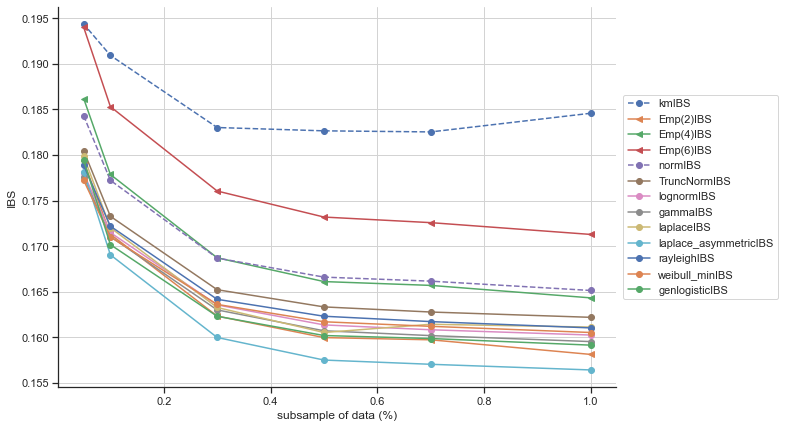

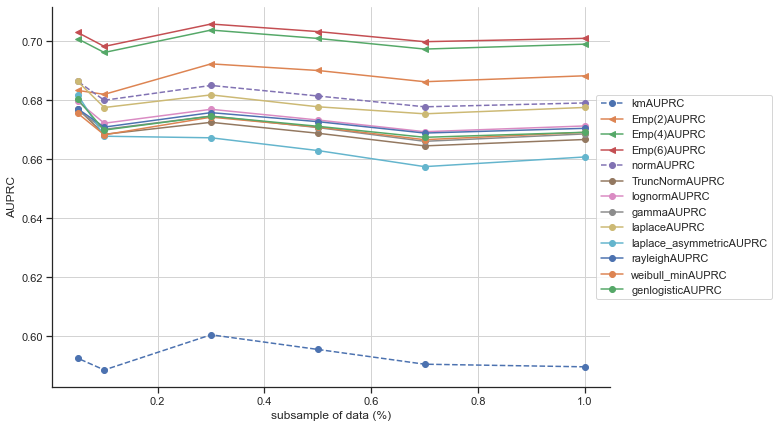

PBC


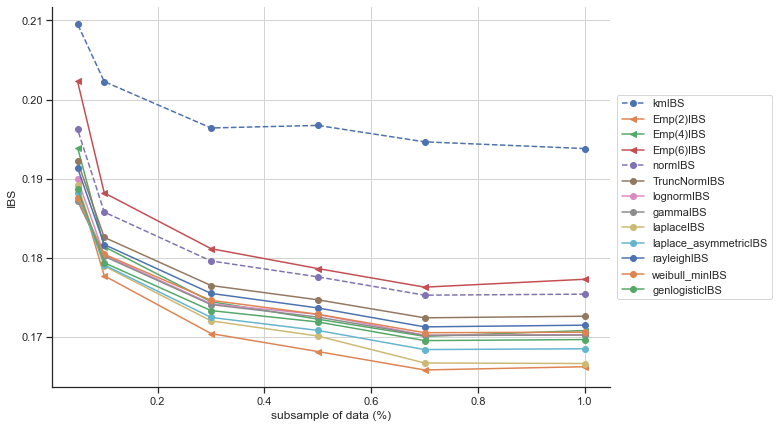

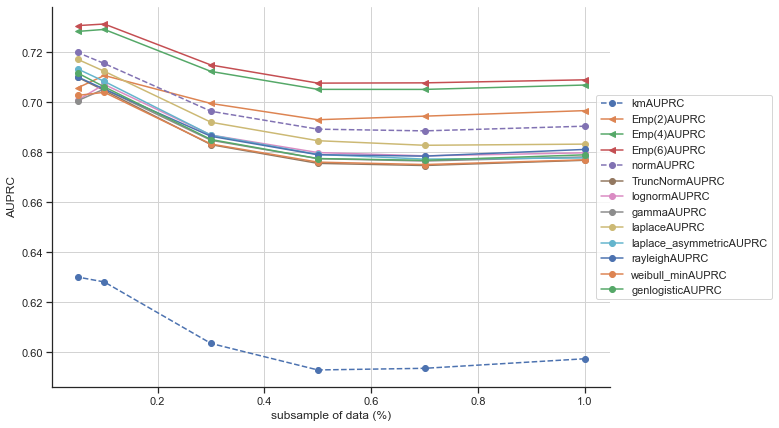

WUHAN


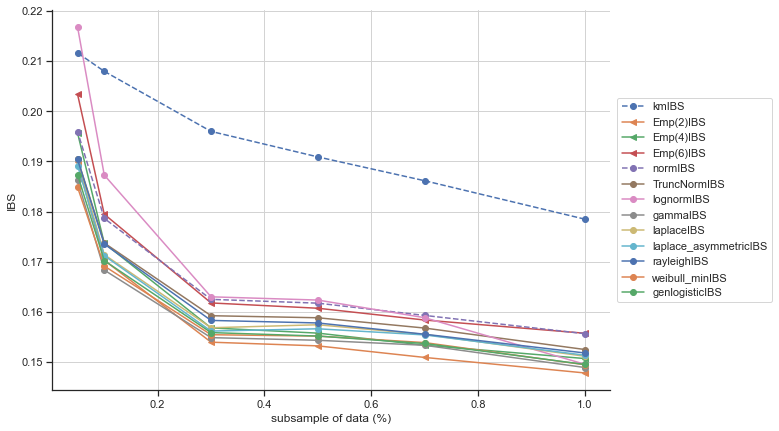

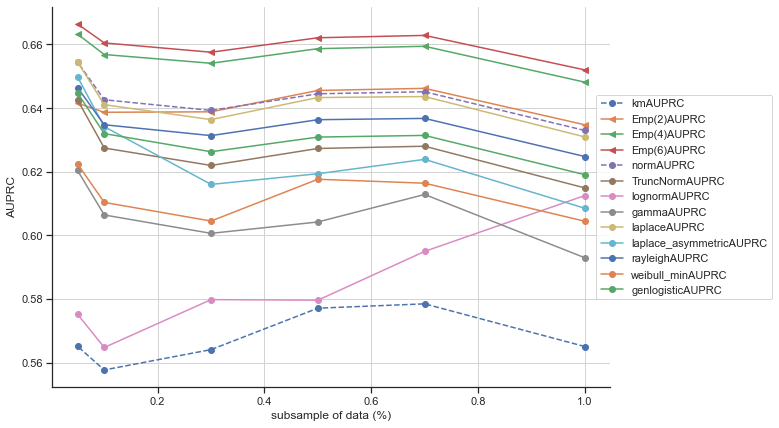

rott2


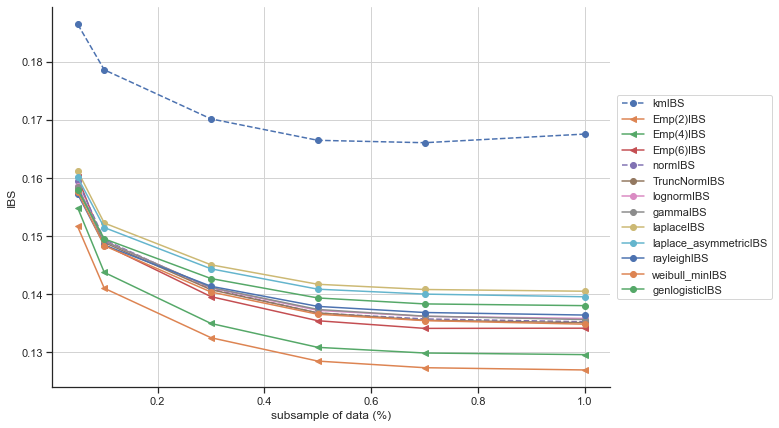

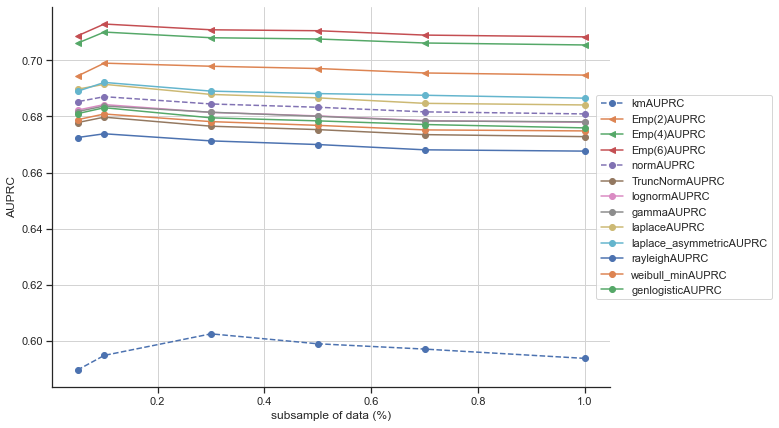

smarto


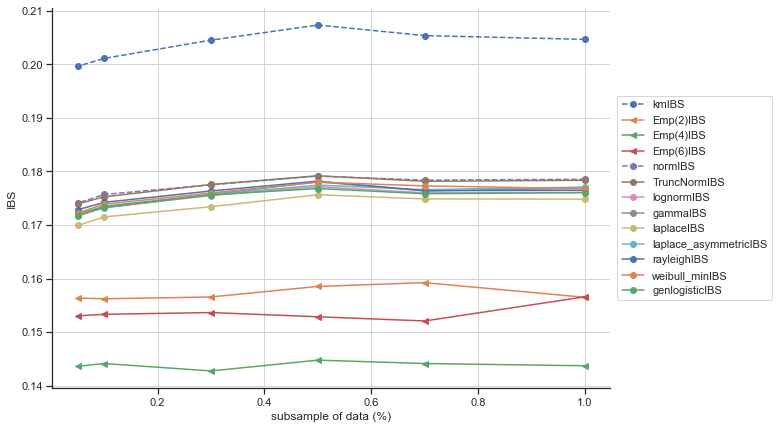

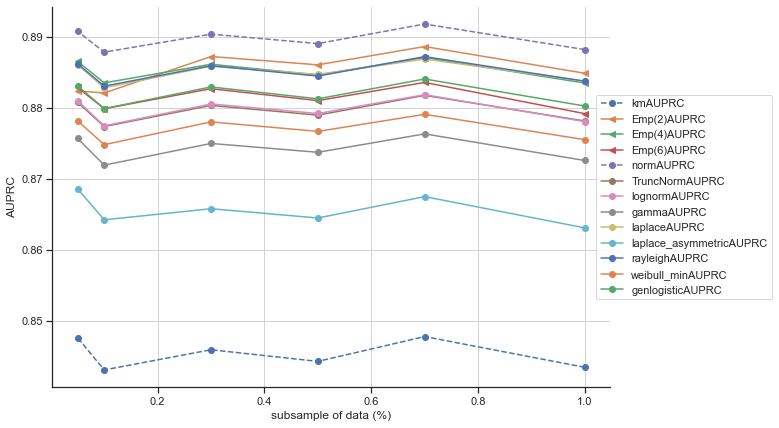

support2


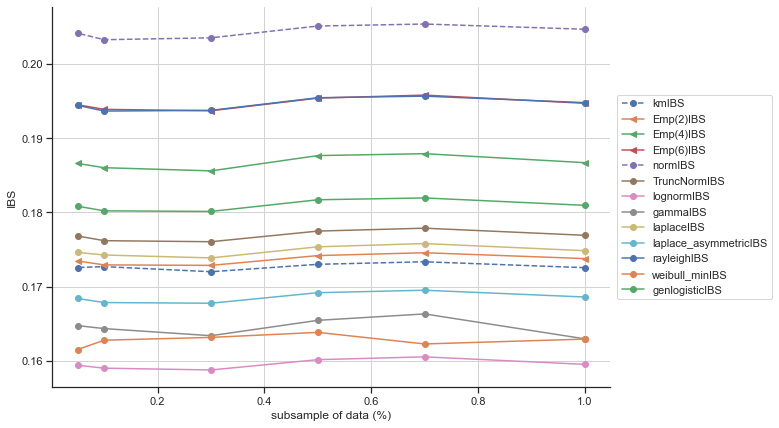

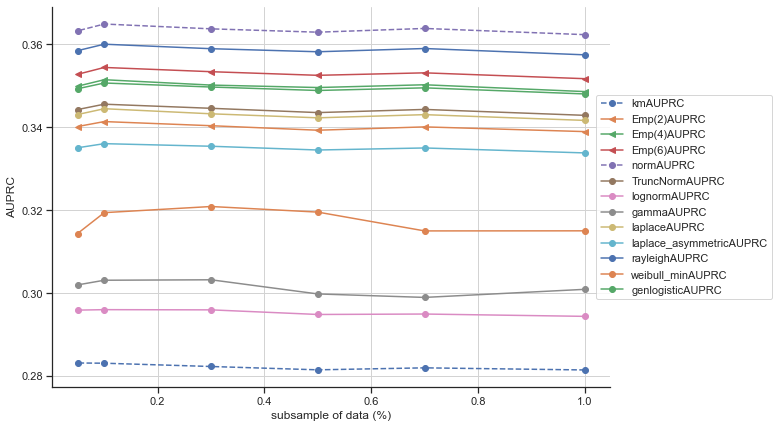

In [417]:
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    print(ds_name)
    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], 1 - df_[c] / df_["kmIBS"], label=c)
    plt.ylabel("IBS")
    plt.xlabel("subsample of data (%)")
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[1:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], df_[c] / df_["kmAUPRC"] - 1, label=c)
    #plt.legend()
    plt.ylabel("AUPRC")
    plt.xlabel("subsample of data (%)")
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

In [270]:
print(df_res.iloc[:-2:2].rank().mean(axis=1).sort_values())
print(df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

for g in df_res.loc["dataset"].unique():
    print("="*10, g, "="*10)
    g_sample = (df_res.T[df_res.T["dataset"] == g]).T
    print(g_sample.iloc[:-2:2].rank().mean(axis=1).sort_values())
    print(g_sample.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

Emp(2)IBS                 2.833333
gammaIBS                  4.805556
weibull_minIBS            4.861111
laplace_asymmetricIBS     5.416667
genlogisticIBS            5.777778
Emp(4)IBS                 6.138889
lognormIBS                6.138889
laplaceIBS                6.500000
rayleighIBS               8.611111
TruncNormIBS              8.805556
Emp(6)IBS                 8.833333
normIBS                  10.638889
kmIBS                    11.638889
dtype: float64
Emp(6)AUPRC                 2.305556
Emp(4)AUPRC                 2.555556
normAUPRC                   3.194444
Emp(2)AUPRC                 4.416667
laplaceAUPRC                4.972222
rayleighAUPRC               6.472222
genlogisticAUPRC            7.222222
laplace_asymmetricAUPRC     8.583333
lognormAUPRC                8.750000
TruncNormAUPRC              9.277778
gammaAUPRC                 10.055556
weibull_minAUPRC           10.194444
kmAUPRC                    13.000000
dtype: float64
========== GBSG ==========
laplace

In [368]:
# Mean (by dataset) ranked methods by meaning quality by subsample
df_pivot = pd.pivot(df_res.T, columns=["dataset"], index="subsample")

df_ibs_pivot = df_pivot.T.mean(axis=1).unstack()[::2]
df_auprc_pivot = df_pivot.T.mean(axis=1).unstack()[1::2]

df_ibs_rank = df_ibs_pivot.rank().mean(axis=1)
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_auprc_pivot.rank(ascending=False).mean(axis=1)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

Emp(2)                 3.333333
Emp(4)                 4.416667
Emp(6)                 5.500000
laplace                5.750000
genlogistic            6.500000
norm                   6.750000
laplace_asymmetric     6.916667
gamma                  7.416667
weibull_min            7.583333
rayleigh               7.750000
lognorm                7.833333
TruncNorm              8.916667
km                    12.333333
dtype: float64


In [367]:
# Mean quality by dataset and subsample
print(df_res.iloc[:-2:2].mean(axis=1).sort_values()) # .rank(ascending=False)
print(df_res.iloc[1:-2:2].mean(axis=1).sort_values())

Emp(2)IBS                0.160775
Emp(4)IBS                 0.16349
weibull_minIBS           0.164003
gammaIBS                 0.164178
laplace_asymmetricIBS    0.165156
lognormIBS               0.165466
laplaceIBS               0.166541
genlogisticIBS           0.167132
TruncNormIBS              0.16804
rayleighIBS              0.170371
Emp(6)IBS                0.170486
normIBS                  0.174419
kmIBS                    0.188247
dtype: object
kmAUPRC                    0.582033
lognormAUPRC               0.633821
gammaAUPRC                 0.636774
weibull_minAUPRC           0.640281
laplace_asymmetricAUPRC     0.64524
TruncNormAUPRC             0.647322
genlogisticAUPRC           0.650446
rayleighAUPRC              0.652028
laplaceAUPRC               0.655306
Emp(2)AUPRC                0.658284
normAUPRC                  0.660292
Emp(4)AUPRC                0.668905
Emp(6)AUPRC                0.670601
dtype: object


In [386]:
df_ibs_rank = df_res.iloc[:-2:2].rank().mean(axis=1)
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print("="*10, "IBS", "="*10)
print(df_ibs_rank.sort_values())
print("="*10, "AUPRC", "="*10)
print(df_auprc_rank.sort_values())
print("="*10, "Mean", "="*10)
print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

========== IBS ==========
Emp(2)                 2.833333
gamma                  4.805556
weibull_min            4.861111
laplace_asymmetric     5.416667
genlogistic            5.777778
Emp(4)                 6.138889
lognorm                6.138889
laplace                6.500000
rayleigh               8.611111
TruncNorm              8.805556
Emp(6)                 8.833333
norm                  10.638889
km                    11.638889
dtype: float64
========== AUPRC ==========
Emp(6)                 2.305556
Emp(4)                 2.555556
norm                   3.194444
Emp(2)                 4.416667
laplace                4.972222
rayleigh               6.472222
genlogistic            7.222222
laplace_asymmetric     8.583333
lognorm                8.750000
TruncNorm              9.277778
gamma                 10.055556
weibull_min           10.194444
km                    13.000000
dtype: float64
========== Mean ==========
Emp(2)                 3.625000
Emp(4)                 4.

In [379]:
from IPython.display import display

# IBS growth
df_IBS_growth = 1 - df_res.iloc[:-2:2] / df_res.iloc[[0]].values
display(df_IBS_growth)

df_IBS_growth_rank = df_IBS_growth.mean(axis=1).rank(ascending=False)
df_IBS_growth_rank.index = df_IBS_growth_rank.index.str[:-3]

# AUPRC growth
df_AUPRC_growth = df_res.iloc[1:-2:2] / df_res.iloc[[1]].values - 1
display(df_AUPRC_growth)

df_AUPRC_growth_rank = df_AUPRC_growth.mean(axis=1).rank(ascending=False)
df_AUPRC_growth_rank.index = df_AUPRC_growth_rank.index.str[:-5]
print(pd.concat([df_IBS_growth_rank, df_AUPRC_growth_rank], axis=1).mean(axis=1).sort_values())

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmIBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)IBS,0.143348,0.124935,0.124168,0.113014,0.102748,0.077462,0.142242,0.148083,0.145246,0.132283,...,0.235433,0.234516,0.223221,0.216788,-0.0071,-0.007036,-0.006795,-0.004973,-0.001349,-0.005084
Emp(4)IBS,0.109737,0.092234,0.090531,0.078077,0.068416,0.042065,0.118646,0.126252,0.124464,0.111773,...,0.30181,0.302076,0.283318,0.280665,-0.082004,-0.084017,-0.084676,-0.079006,-0.077182,-0.081267
Emp(6)IBS,0.072037,0.054521,0.051779,0.038062,0.029434,0.001844,0.085231,0.094329,0.091945,0.077662,...,0.262741,0.248755,0.237601,0.233451,-0.128371,-0.129556,-0.129458,-0.12609,-0.122697,-0.127091
normIBS,0.105335,0.089688,0.087853,0.078238,0.071782,0.051787,0.094934,0.099535,0.097276,0.085569,...,0.136037,0.132131,0.126324,0.127943,-0.186188,-0.184803,-0.18558,-0.183235,-0.177041,-0.182972
TruncNormIBS,0.121293,0.108236,0.105742,0.097213,0.092446,0.071564,0.109322,0.114238,0.112014,0.101359,...,0.135787,0.131793,0.128579,0.128728,-0.025283,-0.026111,-0.025875,-0.023503,-0.02024,-0.024623
lognormIBS,0.131814,0.118902,0.116551,0.106313,0.101803,0.084342,0.12132,0.125497,0.121381,0.113135,...,0.14564,0.14194,0.138432,0.139143,0.075491,0.073898,0.074262,0.076951,0.079235,0.076307
gammaIBS,0.135712,0.122408,0.120083,0.109327,0.104063,0.086302,0.121645,0.125681,0.123098,0.113652,...,0.141203,0.140908,0.137355,0.138373,0.055567,0.040531,0.043636,0.05012,0.04836,0.04535
laplaceIBS,0.127086,0.115593,0.12111,0.107873,0.098983,0.07464,0.140167,0.143552,0.135287,0.124118,...,0.152842,0.152097,0.147187,0.148905,-0.013267,-0.014162,-0.013641,-0.010819,-0.009058,-0.011807
laplace_asymmetricIBS,0.152567,0.139648,0.137661,0.125846,0.114575,0.083403,0.130552,0.134834,0.131681,0.121881,...,0.144172,0.141158,0.138799,0.138686,0.022901,0.022116,0.022092,0.024687,0.028031,0.02417


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmAUPRC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)AUPRC,0.16722,0.162064,0.158698,0.152839,0.158638,0.1531,0.166135,0.169914,0.168812,0.159051,...,0.04947,0.048823,0.046275,0.041005,0.204315,0.206175,0.205363,0.205789,0.205931,0.201468
Emp(4)AUPRC,0.185388,0.180794,0.176933,0.171909,0.182737,0.18263,0.183266,0.187936,0.18929,0.18029,...,0.047789,0.047533,0.047958,0.045908,0.238612,0.242209,0.241957,0.240512,0.241606,0.235848
Emp(6)AUPRC,0.188738,0.185028,0.180832,0.175317,0.18622,0.186246,0.186761,0.192355,0.193497,0.184527,...,0.043502,0.043464,0.043645,0.041572,0.249669,0.252416,0.252416,0.251957,0.25206,0.245967
normAUPRC,0.151625,0.147672,0.144192,0.140667,0.155236,0.158334,0.155713,0.159997,0.162437,0.153888,...,0.053016,0.052549,0.053093,0.050905,0.287408,0.290399,0.289381,0.288574,0.289068,0.283014
TruncNormAUPRC,0.130616,0.125256,0.122997,0.119858,0.135626,0.142674,0.13289,0.13666,0.139373,0.131746,...,0.041081,0.040682,0.040669,0.039133,0.218254,0.221107,0.220468,0.220663,0.220752,0.215934
lognormAUPRC,0.138397,0.133386,0.13053,0.12721,0.142022,0.146904,0.137877,0.143175,0.146657,0.138143,...,0.041354,0.040921,0.040777,0.039365,0.045946,0.046041,0.047437,0.048406,0.045642,0.04504
gammaAUPRC,0.133819,0.127871,0.126217,0.123361,0.138501,0.141823,0.135125,0.13968,0.142537,0.134651,...,0.034882,0.03435,0.034217,0.03312,0.069112,0.060264,0.065037,0.074106,0.070715,0.066522
laplaceAUPRC,0.149027,0.143657,0.138048,0.135341,0.151063,0.158268,0.143706,0.150286,0.154649,0.146607,...,0.047871,0.047199,0.047138,0.045379,0.213915,0.216644,0.215989,0.215969,0.216895,0.2117
laplace_asymmetricAUPRC,0.120581,0.113347,0.113149,0.111128,0.134541,0.150696,0.134445,0.140976,0.145396,0.138072,...,0.023922,0.023481,0.025083,0.024732,0.18604,0.188135,0.188402,0.188235,0.187117,0.183364


Emp(2)                 2.5
Emp(4)                 2.5
Emp(6)                 6.0
laplace                6.0
weibull_min            6.0
norm                   7.5
gamma                  7.5
laplace_asymmetric     7.5
genlogistic            7.5
rayleigh               8.0
TruncNorm              8.5
lognorm                8.5
km                    13.0
dtype: float64
